<a href="https://www.kaggle.com/code/septianbagussantoso/tugas-machine-learning-ds-unsw-nb15-kelompok-8?scriptVersionId=247257983" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/NUSW-NB15_features.csv


In [2]:
# === IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

2025-06-25 06:54:20.119012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750834460.411403      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750834460.499868      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# === LOAD DATA (HANYA TRAINING SET) ===
train_path = "/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_training-set.csv"
df = pd.read_csv(train_path)

In [4]:
# === SPLIT FITUR & LABEL ===
X = df.drop(columns=["label", "attack_cat"])
y = df["label"]

In [5]:
# === ENCODING FITUR KATEGORIK ===
categorical_columns = X.select_dtypes(include=["object"]).columns
encoders = {}

for col in categorical_columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))
    encoders[col] = encoder

In [6]:
# === NORMALISASI ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# === SPLIT TRAIN / TEST ===
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# === SPLIT TRAIN / VALIDASI DARI TRAIN_ALL ===
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all
)

In [9]:
# === DATA BINARISASI UNTUK BERNOULLI NB ===
median_vals = np.median(X_train, axis=0)
X_train_bin = (X_train > median_vals).astype(int)
X_val_bin = (X_val > median_vals).astype(int)
X_test_bin = (X_test > median_vals).astype(int)

In [10]:
# === INISIALISASI MODEL ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(probability=True),
    "Naïve Bayes": BernoulliNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extreme Gradient Boosting": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

In [11]:
# === CNN DENGAN DROPOUT, L2 REGULASI, DAN LAYER TAMBAHAN ===
def create_optimized_cnn(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_optimized_cnn(X_train.shape[1])
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=64, verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-25 06:54:38.868019: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8789 - loss: 0.5047 - val_accuracy: 0.9655 - val_loss: 0.2045
Epoch 2/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9591 - loss: 0.1950 - val_accuracy: 0.9724 - val_loss: 0.1298
Epoch 3/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9717 - loss: 0.1361 - val_accuracy: 0.9818 - val_loss: 0.1064
Epoch 4/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9800 - loss: 0.1114 - val_accuracy: 0.9903 - val_loss: 0.0810
Epoch 5/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9853 - loss: 0.0907 - val_accuracy: 0.9922 - val_loss: 0.0711
Epoch 6/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9857 - loss: 0.0863 - val_accuracy: 0.9887 - val_loss: 0.0761
Epoch 7/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9865 - loss: 0.0793 - val_accuracy: 0.9950 - val_loss: 0.0597
Epoch 8/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9860 - loss: 0.0799 - val_accu

In [12]:
# List untuk menyimpan hasil evaluasi
val_results = []
test_results = []

print("\n\U0001F4CB Detail Evaluasi Model Klasik:")
for name, model in models.items():
    print(f"Training {name}...")
    if name == "Naïve Bayes":
        model.fit(X_train_bin, y_train)
        y_val_pred = model.predict(X_val_bin)
        y_test_pred = model.predict(X_test_bin)
        y_val_proba = model.predict_proba(X_val_bin)[:, 1]
        y_test_proba = model.predict_proba(X_test_bin)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else y_val_pred
        y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_test_pred

    val_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1-Score": f1_score(y_val, y_val_pred),
        "AUC": roc_auc_score(y_val, y_val_proba),
        "Loss": 1 - accuracy_score(y_val, y_val_pred)
    })

    test_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "AUC": roc_auc_score(y_test, y_test_proba),
        "Loss": 1 - accuracy_score(y_test, y_test_pred)
    })


📋 Detail Evaluasi Model Klasik:
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Support Vector Machine...
Training Naïve Bayes...
Training K-Nearest Neighbors...
Training AdaBoost...
Training Extreme Gradient Boosting...
Training Linear Discriminant Analysis...
Training Stochastic Gradient Descent...
Training Neural Network (MLP)...


In [13]:
# === Evaluasi CNN ===
y_val_pred_cnn = (cnn_model.predict(X_val) > 0.5).astype(int)
y_test_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype(int)
y_val_proba_cnn = cnn_model.predict(X_val).flatten()
y_test_proba_cnn = cnn_model.predict(X_test).flatten()

val_results.append({
    "Model": "CNN",
    "Accuracy": accuracy_score(y_val, y_val_pred_cnn),
    "Precision": precision_score(y_val, y_val_pred_cnn),
    "Recall": recall_score(y_val, y_val_pred_cnn),
    "F1-Score": f1_score(y_val, y_val_pred_cnn),
    "AUC": roc_auc_score(y_val, y_val_proba_cnn),
    "Loss": 1 - accuracy_score(y_val, y_val_pred_cnn)
})

test_results.append({
    "Model": "CNN",
    "Accuracy": accuracy_score(y_test, y_test_pred_cnn),
    "Precision": precision_score(y_test, y_test_pred_cnn),
    "Recall": recall_score(y_test, y_test_pred_cnn),
    "F1-Score": f1_score(y_test, y_test_pred_cnn),
    "AUC": roc_auc_score(y_test, y_test_proba_cnn),
    "Loss": 1 - accuracy_score(y_test, y_test_pred_cnn)
})

412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [14]:
# === KONVERSI KE DATAFRAME ===
val_df = pd.DataFrame(val_results)
test_df = pd.DataFrame(test_results)

In [15]:
# === CETAK TABEL ===
print("\n\U0001F4CB Validation Set Metrics:")
print(val_df.round(4))
print("\n\U0001F4CB Test Set Metrics:")
print(test_df.round(4))


📋 Validation Set Metrics:
                           Model  Accuracy  Precision  Recall  F1-Score  \
0            Logistic Regression    0.9504     0.9501  0.9603    0.9552   
1                  Decision Tree    0.9996     0.9996  0.9997    0.9997   
2                  Random Forest    0.9994     0.9993  0.9996    0.9994   
3         Support Vector Machine    0.9702     0.9600  0.9869    0.9733   
4                    Naïve Bayes    0.6878     0.7437  0.6606    0.6997   
5            K-Nearest Neighbors    0.9768     0.9818  0.9760    0.9789   
6                       AdaBoost    1.0000     1.0000  1.0000    1.0000   
7      Extreme Gradient Boosting    0.9994     0.9996  0.9993    0.9994   
8   Linear Discriminant Analysis    0.9232     0.9262  0.9349    0.9306   
9    Stochastic Gradient Descent    0.9529     0.9508  0.9644    0.9576   
10          Neural Network (MLP)    0.9975     0.9974  0.9981    0.9977   
11                           CNN    0.9923     0.9926  0.9935    0.9930  

/tmp/ipykernel_13/8888350.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


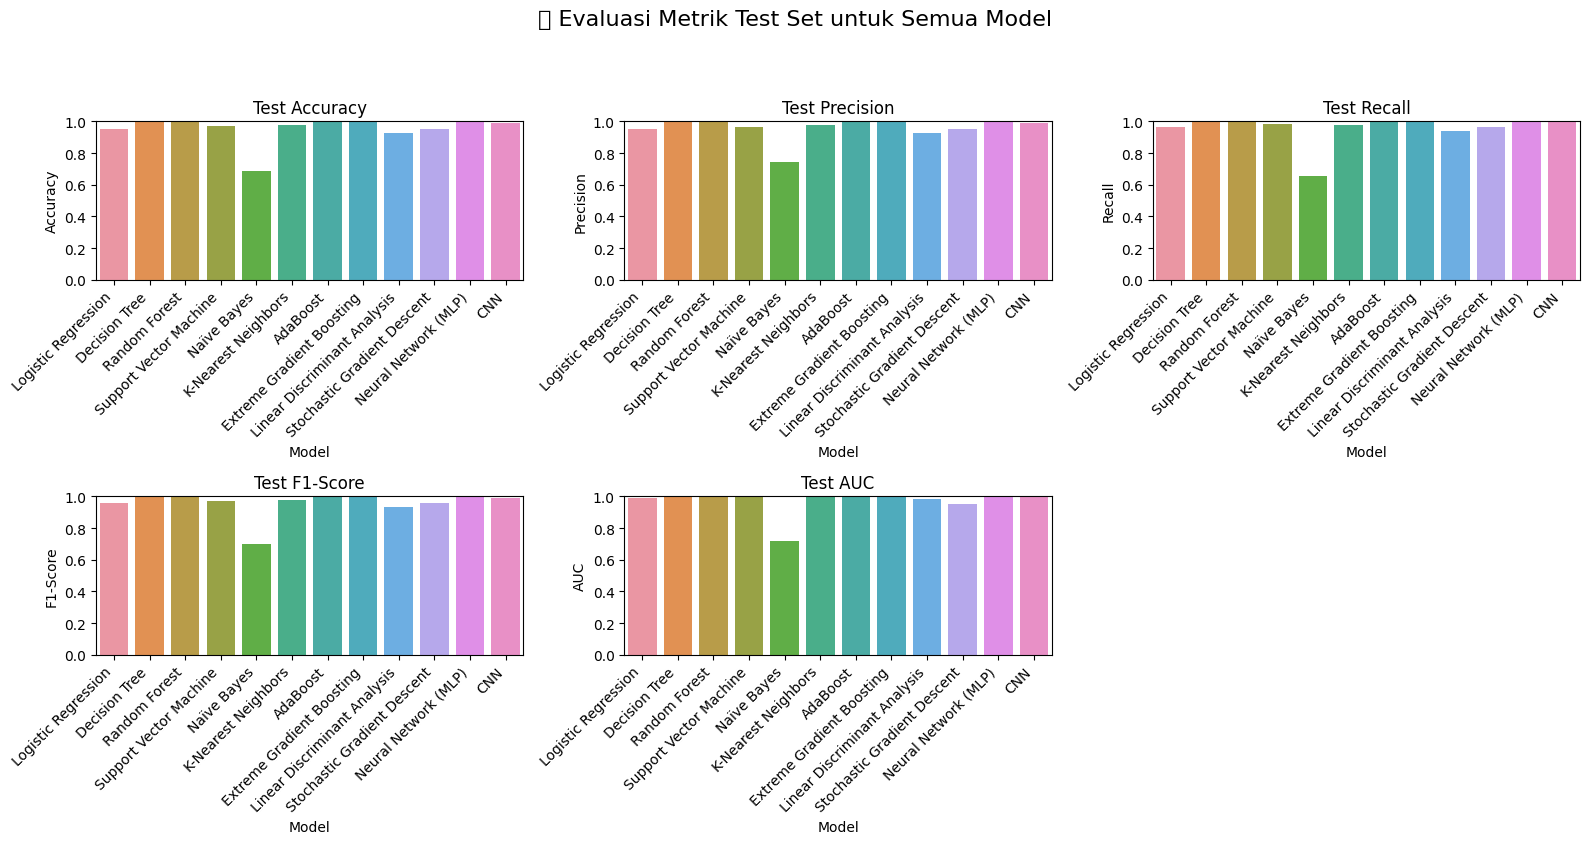

In [16]:
# === VISUALISASI METRIK TEST ===
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=test_df, x="Model", y=metric)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Test {metric}")
    plt.ylim(0, 1)
    plt.tight_layout()

plt.suptitle("\U0001F4CA Evaluasi Metrik Test Set untuk Semua Model", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

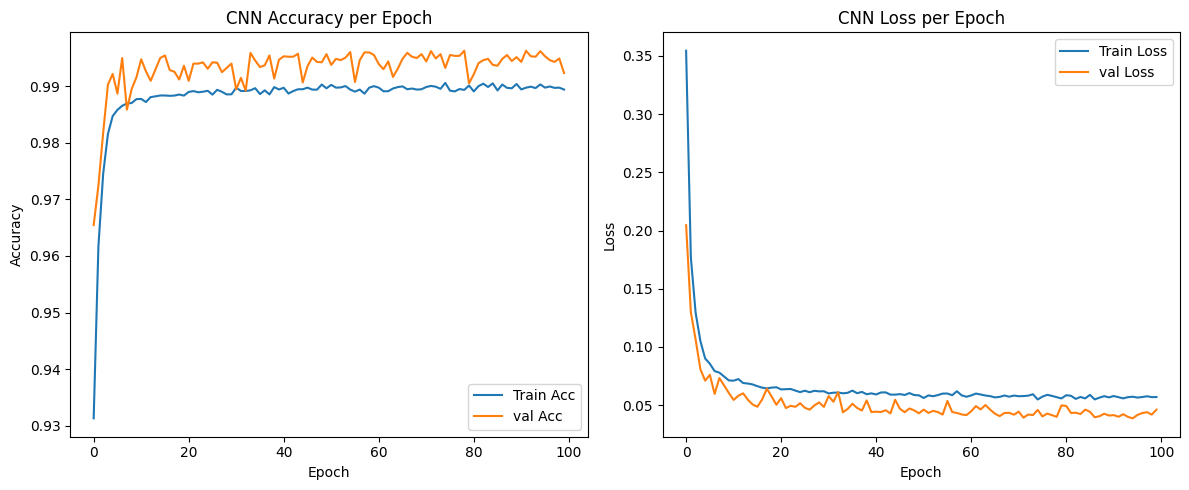

In [17]:
# === GRAFIK HISTORI TRAINING CNN ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='val Acc')
plt.title('CNN Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.title('CNN Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
print("Ukuran data:", df.shape)
print("\nInfo data:")
print(df.info())
print("\nBeberapa baris awal:")
print(df.head())
print("\nStatistik ringkas:")
print(df.describe())
print("\nDistribusi label:")
print(df['label'].value_counts())

Ukuran data: (82332, 45)

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null


📊 Evaluasi 5-Fold Cross-Validation Model Klasik:
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Support Vector Machine...
Evaluating Naïve Bayes...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...
Evaluating Extreme Gradient Boosting...
Evaluating Linear Discriminant Analysis...
Evaluating Stochastic Gradient Descent...
Evaluating Neural Network (MLP)...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8944 - loss: 0.4811 - val_accuracy: 0.9635 - val_loss: 0.1882
Epoch 2/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9600 - loss: 0.1859 - val_accuracy: 0.9696 - val_loss: 0.1278
Epoch 3/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9719 - loss: 0.1339 - val_accuracy: 0.9857 - val_loss: 0.0969
Epoch 4/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9819 - loss: 0.1036 - val_accuracy: 0.9911 - val_loss: 0.0753
Epoch 5/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9837 - loss: 0.0934 - val_accuracy: 0.9930 - val_loss: 0.0685
Epoch 6/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9856 - loss: 0.0826 - val_accuracy: 0.9904 - val_loss: 0.0698
Epoch 7/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9860 - loss: 0.0807 - val_accuracy: 0.9939 - val_loss: 0.0592
Epoch 8/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9862 - loss: 0.0772 - val_accuracy: 0.9942

/tmp/ipykernel_13/3350755431.py:148: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


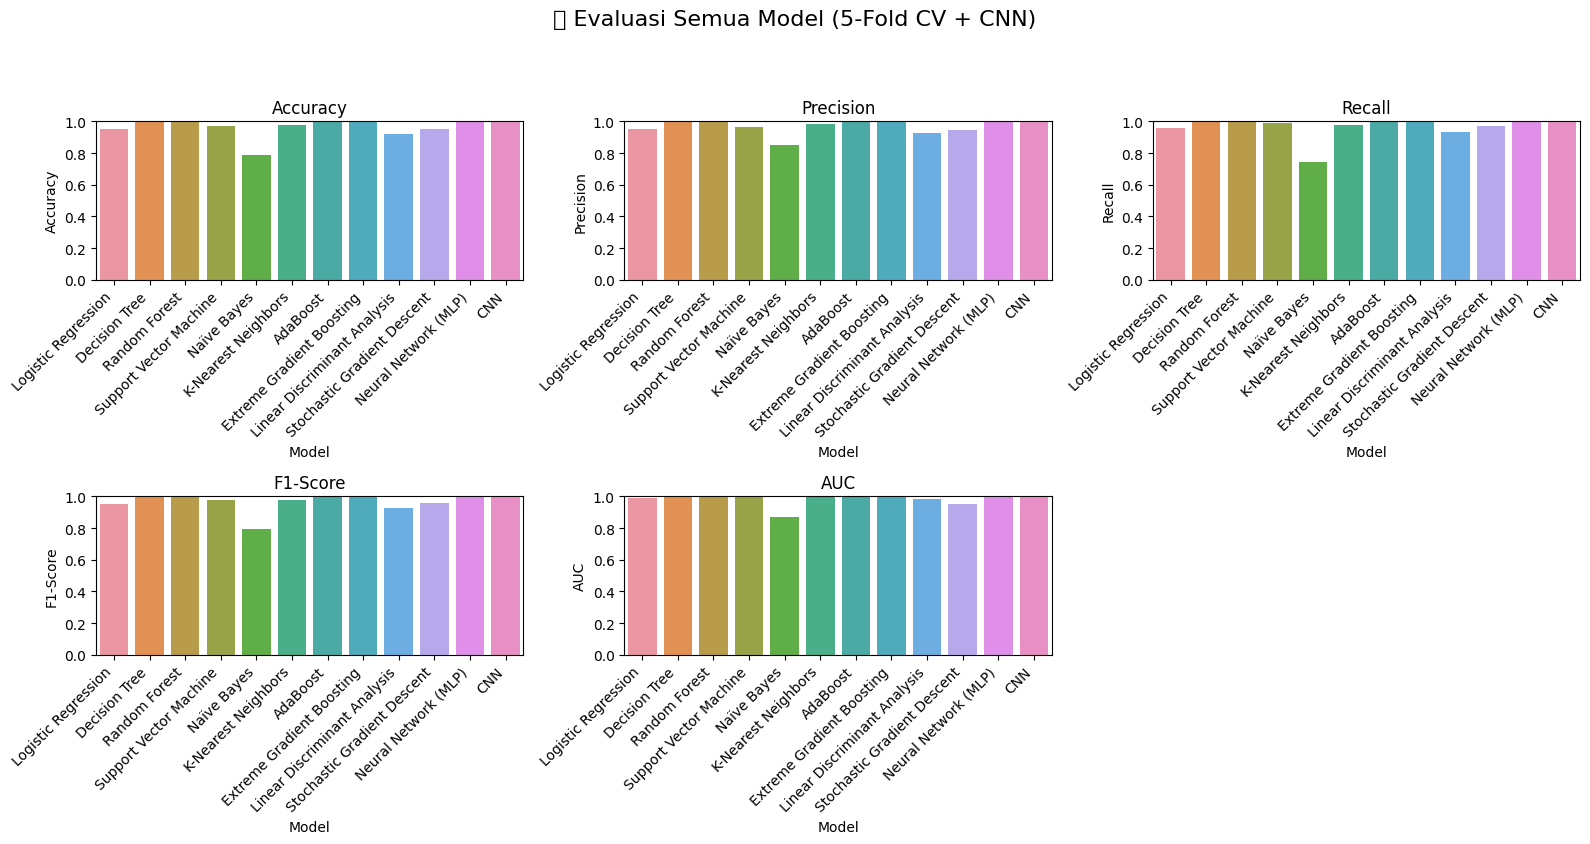

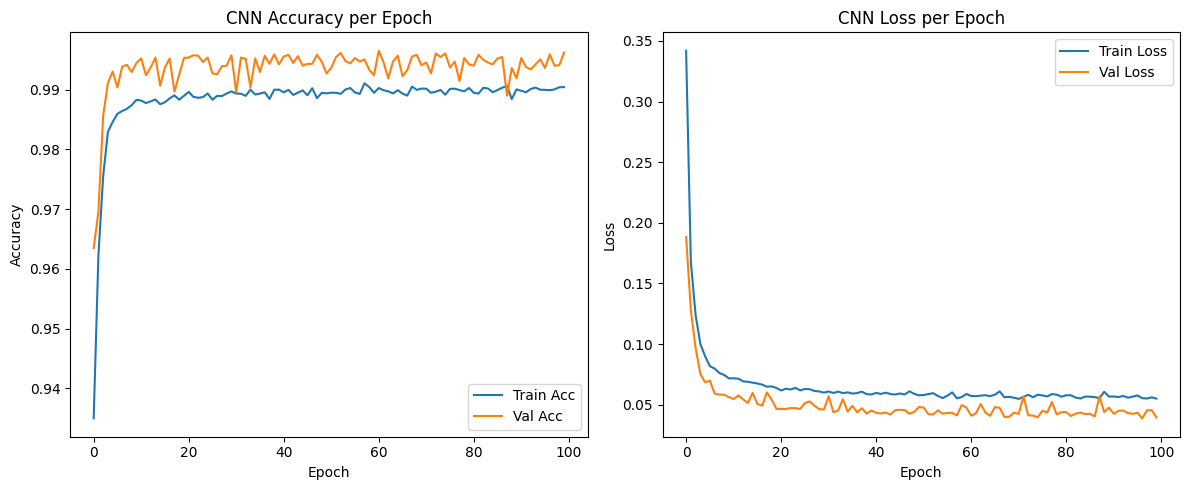

Ukuran data: (82332, 45)

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null

In [19]:
# === IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

# === LOAD DATA (HANYA TRAINING SET) ===
train_path = "/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_training-set.csv"
df = pd.read_csv(train_path)

# === SPLIT FITUR & LABEL ===
X = df.drop(columns=["label", "attack_cat"])
y = df["label"]

# === ENCODING FITUR KATEGORIK ===
categorical_columns = X.select_dtypes(include=["object"]).columns
encoders = {}

for col in categorical_columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))
    encoders[col] = encoder

# === NORMALISASI ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === SPLIT KHUSUS CNN (Bukan untuk model klasik) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# === INISIALISASI MODEL ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(probability=True),
    "Naïve Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extreme Gradient Boosting": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# === CROSS VALIDATION UNTUK SEMUA MODEL KLASIK ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

print("\n📊 Evaluasi 5-Fold Cross-Validation Model Klasik:")
for name, model in models.items():
    print(f"Evaluating {name}...")
    if name == "Naïve Bayes":
        y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
        y_proba = cross_val_predict(model, X_scaled, y, cv=skf, method='predict_proba')[:, 1]
    else:
        y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
        if hasattr(model, "predict_proba"):
            y_proba = cross_val_predict(model, X_scaled, y, cv=skf, method='predict_proba')[:, 1]
        else:
            y_proba = y_pred

    cv_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-Score": f1_score(y, y_pred),
        "AUC": roc_auc_score(y, y_proba),
        "Loss": 1 - accuracy_score(y, y_pred)
    })

cv_df = pd.DataFrame(cv_results)

# === DEFINISI CNN DENGAN DROPOUT & L2 ===
def create_optimized_cnn(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_optimized_cnn(X_train_cnn.shape[1])
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=100, batch_size=64, verbose=1
)

# === EVALUASI CNN ===
y_val_pred_cnn = (cnn_model.predict(X_val_cnn) > 0.5).astype(int)
y_val_proba_cnn = cnn_model.predict(X_val_cnn).flatten()

cv_df = pd.concat([cv_df, pd.DataFrame([{
    "Model": "CNN",
    "Accuracy": accuracy_score(y_val_cnn, y_val_pred_cnn),
    "Precision": precision_score(y_val_cnn, y_val_pred_cnn),
    "Recall": recall_score(y_val_cnn, y_val_pred_cnn),
    "F1-Score": f1_score(y_val_cnn, y_val_pred_cnn),
    "AUC": roc_auc_score(y_val_cnn, y_val_proba_cnn),
    "Loss": 1 - accuracy_score(y_val_cnn, y_val_pred_cnn)
}])], ignore_index=True)

# === TAMPILKAN TABEL HASIL ===
print("\n📋 Hasil Cross-Validation dan CNN:")
print(cv_df.round(4))

# === VISUALISASI ===
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=cv_df, x="Model", y=metric)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{metric}")
    plt.ylim(0, 1)
    plt.tight_layout()

plt.suptitle("📊 Evaluasi Semua Model (5-Fold CV + CNN)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# === GRAFIK HISTORI TRAINING CNN ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# === INFO DATASET ===
print("Ukuran data:", df.shape)
print("\nInfo data:")
print(df.info())
print("\nBeberapa baris awal:")
print(df.head())
print("\nStatistik ringkas:")
print(df.describe())
print("\nDistribusi label:")
print(df['label'].value_counts())



📊 Evaluasi 5-Fold Cross-Validation Model Klasik:
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Support Vector Machine...
Evaluating Naïve Bayes...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...
Evaluating Extreme Gradient Boosting...
Evaluating Linear Discriminant Analysis...
Evaluating Stochastic Gradient Descent...
Evaluating Neural Network (MLP)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

📋 Hasil Cross-Validation dan CNN:
                           Model  Accuracy  Precision  Recall  F1-Score  \
0            Logistic Regression    0.9496     0.9504  0.9584    0.9544   
1                  Decision Tree    0.9992     0.9992  0.9994    0.9993   
2                  Random Forest    0.9989     0.9982  0.9998    0.9990   
3         Support Vector Machine    0.9718     0.9633  0.9865    0.9747   
4                    Naïve Bayes    0.7850     0.8487  0.7418    0.7916   
5            K-Nearest Neighbors    0.9763     0.9819  0.9751    0.9784   
6                       AdaBoost    1.0000     1.0000  1.0000    1.0000   
7      Extreme Gradient Boosting    0.9997     0.9998  0.9997    0.9998   
8   Linear Discriminant Analysis    0.9207     0.9251  0.9314    0.9283   
9    Stochastic Gradient Descent    0.9546     0.9487  0.9700    0.9592   
10          Neura

/tmp/ipykernel_13/8446164.py:133: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


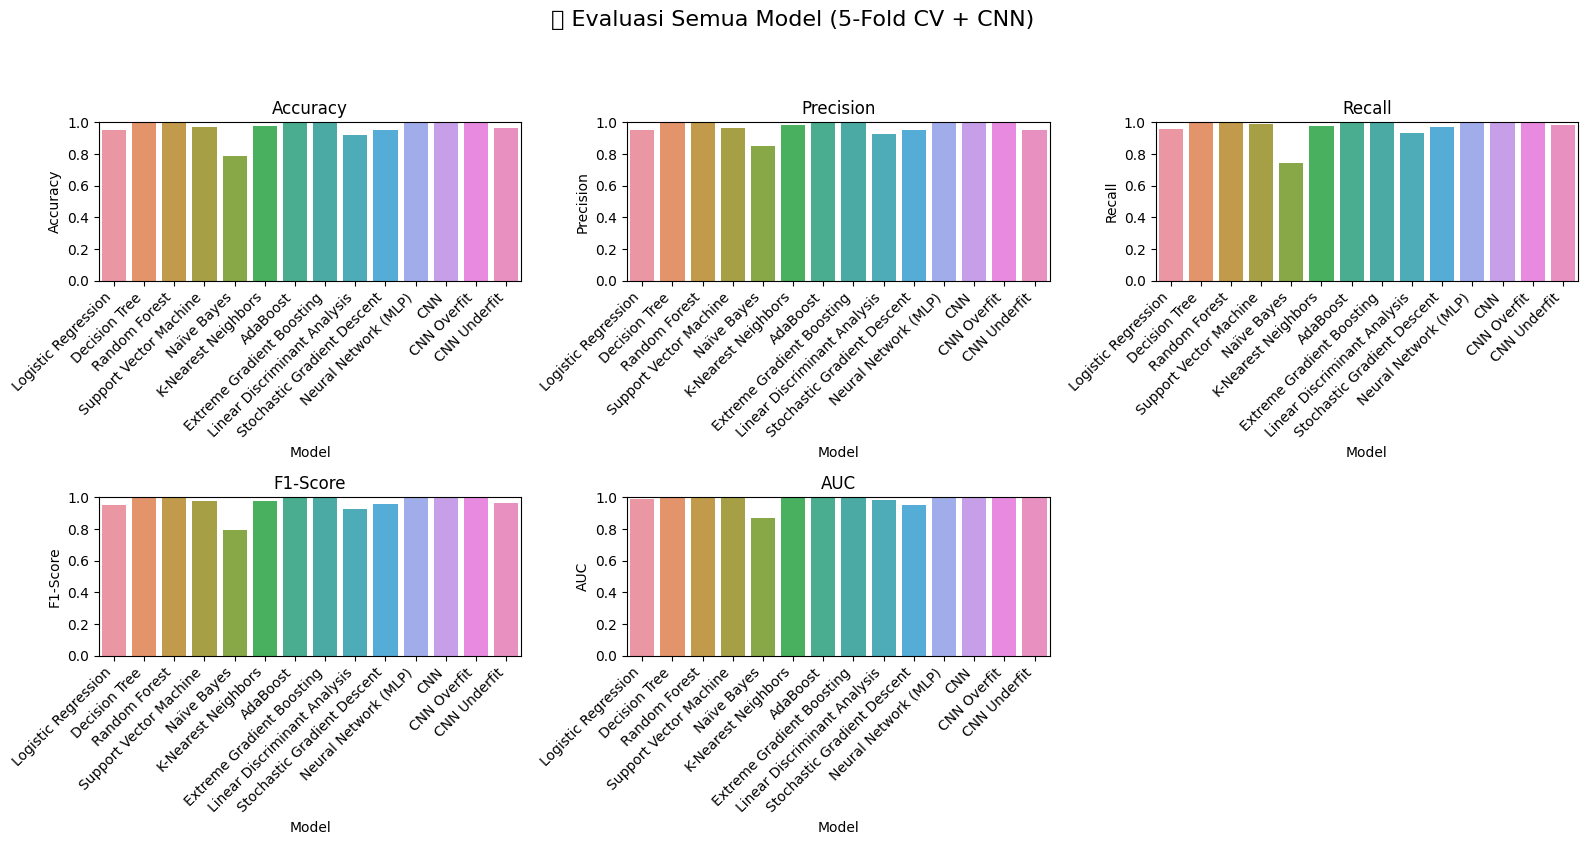

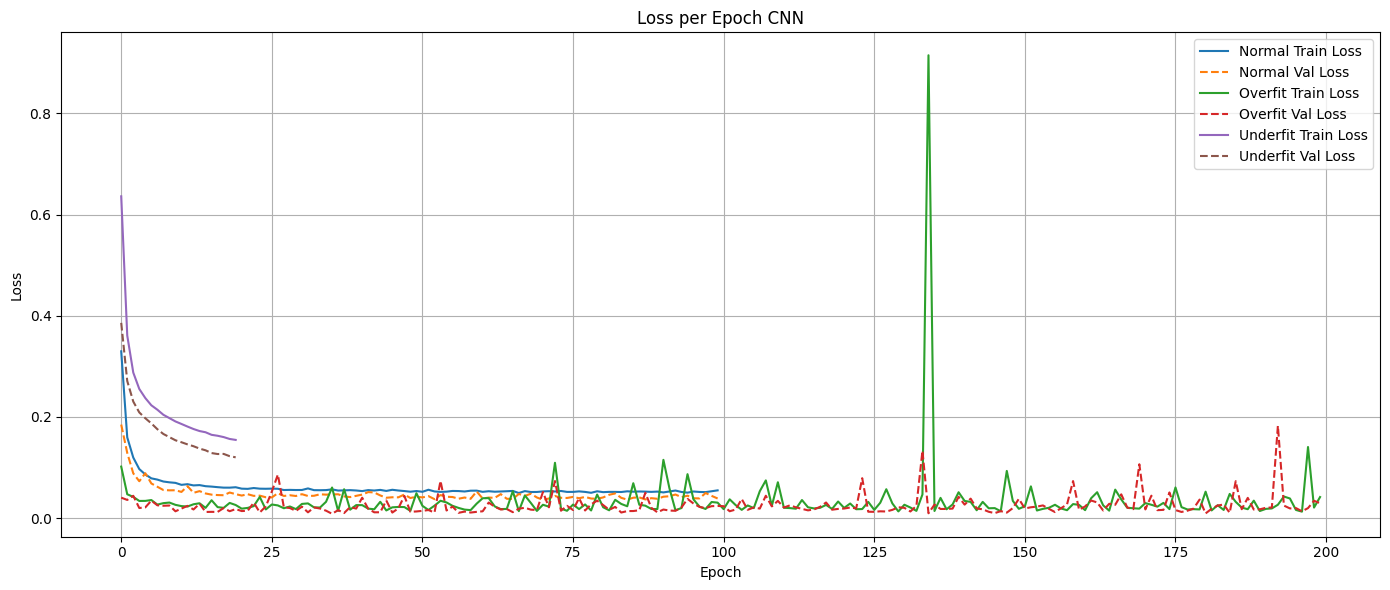

Ukuran data: (82332, 45)

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null

In [20]:
# === IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

# === LOAD DATA (HANYA TRAINING SET) ===
df = pd.read_csv("/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_training-set.csv")

X = df.drop(columns=["label", "attack_cat"])
y = df["label"]

# === ENCODING FITUR KATEGORIK ===
categorical_columns = X.select_dtypes(include=["object"]).columns
encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))
    encoders[col] = encoder

# === SCALING ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# === MODEL KLASIK ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(probability=True),
    "Naïve Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extreme Gradient Boosting": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
print("\n📊 Evaluasi 5-Fold Cross-Validation Model Klasik:")
for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
    y_proba = cross_val_predict(model, X_scaled, y, cv=skf, method='predict_proba')[:, 1] if hasattr(model, "predict_proba") else y_pred
    cv_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-Score": f1_score(y, y_pred),
        "AUC": roc_auc_score(y, y_proba),
        "Loss": 1 - accuracy_score(y, y_pred)
    })

cv_df = pd.DataFrame(cv_results)

# === CNN VERSIONS ===
def build_cnn(input_shape, dropout=0.3, reg=0.001, hidden_layers=[256, 128, 64]):
    model = Sequential()
    for i, units in enumerate(hidden_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(reg)))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Normal CNN
cnn_normal = build_cnn(X_train_cnn.shape[1])
hist_normal = cnn_normal.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=100, batch_size=64, verbose=0)

# Overfit CNN
cnn_overfit = build_cnn(X_train_cnn.shape[1], dropout=0.05, reg=0.0, hidden_layers=[1024, 512, 256])
hist_overfit = cnn_overfit.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=200, batch_size=8, verbose=0)

# Underfit CNN
cnn_underfit = build_cnn(X_train_cnn.shape[1], dropout=0.5, reg=0.01, hidden_layers=[16])
hist_underfit = cnn_underfit.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=20, batch_size=128, verbose=0)

# Evaluasi semua CNN
cnn_models = [("CNN", cnn_normal, hist_normal), ("CNN Overfit", cnn_overfit, hist_overfit), ("CNN Underfit", cnn_underfit, hist_underfit)]
for label, model, _ in cnn_models:
    y_prob = model.predict(X_val_cnn).flatten()
    y_pred = (y_prob > 0.5).astype(int)
    cv_df = pd.concat([cv_df, pd.DataFrame([{
        "Model": label,
        "Accuracy": accuracy_score(y_val_cnn, y_pred),
        "Precision": precision_score(y_val_cnn, y_pred),
        "Recall": recall_score(y_val_cnn, y_pred),
        "F1-Score": f1_score(y_val_cnn, y_pred),
        "AUC": roc_auc_score(y_val_cnn, y_prob),
        "Loss": 1 - accuracy_score(y_val_cnn, y_pred)
    }])], ignore_index=True)

# === HASIL ===
print("\n📋 Hasil Cross-Validation dan CNN:")
print(cv_df.round(4))

# === VISUALISASI HASIL ===
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=cv_df, x="Model", y=metric)
    plt.xticks(rotation=45, ha='right')
    plt.title(metric)
    plt.ylim(0, 1)
plt.suptitle("📊 Evaluasi Semua Model (5-Fold CV + CNN)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# === VISUALISASI PERFORMA CNN ===
def plot_histories(histories, labels):
    plt.figure(figsize=(14, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train Loss')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{label} Val Loss')
    plt.title('Loss per Epoch CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_histories([hist_normal, hist_overfit, hist_underfit], ["Normal", "Overfit", "Underfit"])

# === INFO ===
print("Ukuran data:", df.shape)
print("\nInfo data:")
print(df.info())
print("\nBeberapa baris awal:")
print(df.head())
print("\nStatistik ringkas:")
print(df.describe())
print("\nDistribusi label:")
print(df['label'].value_counts())